In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('display.max_columns', None)

Frame the Problem & Look At the Big Picture 
-------------------------------------------

1. Define the objective in business terms. 
    * The business objective is to predict the stock price for a specific ticker 7 days into the future.
2. How will your solution be used? 
    * The solution will be used to determine when to buy and/or sell stock(s). 
3. What are the current solutions/workarounds (if any)? 
    * There are other people/companies who have attempted to do this with varying levels of success. For many people, they trade stocks using technical analysis which means they intuitively learn trends using various signals (many of which are in the data set).
4. How should you frame this problem?
    * This problem is going to be framed as an offline regression (forecasting) model, but it should ideally be an online model so that it can constantly learn from new data when the stock market is open.
    * If we end up using AWS, then this model will be an online regression model.
5. How should performance be measured?
    * Root mean squared error (RMSE). 
6. What would be the minimum performance needed to reach the business objective?
    * The minimum performance needed would, at the very least, correctly identify the directional trend of price (up or down), but it would additionally be heavily preferable if the prices/change in prices were as close to the true value as possible (minimum distance).
7. What are comparable problems?
    * We have not worked on any other comparable problems that also used time-series data, but there are AWS resources we can look into as well as read the chapter of the textbook on time-series data. 
8. Is human expertise available?
    * {Jeff, Google, StackOverFlow, GitHub CoPilot}
9. How would you solve this problem manually?
    * Ask WSB (lol… unless?)
    * In reality, I would only use a fraction of the indicators that are already provided in the data set (such as MACD, RSI, EMA, VWAP). These indicators are graphed as lines against the price of the stock prices and can be used to infer whether the stock price will move up or down.
10. List the assumptions you have made so far. Verify the assumptions if possible.
    * I am assuming that the data is historically accurate.
    * The types of trends identified for one company can also be applied to others, otherwise you would probably need a separate model for each company.

Get the Data 
----
1. List the data you need and how much you need 
2. Find and document where you can get that data 
3. Get access authorizations 
4. Create a workspace (with enough storage space) 
5. Get the data 
6. Convert the data to a format you can easily manipulate (without changing the data itself) 
7. Ensure sensitive information is deleted or protected (e.g. anonymized) 
8. Check the size and type of data (time series, geographical, ...) 
9. Sample a test set, put it aside, and never look at it (no data snooping!) 

In [5]:
# methods

def load_data():
    """
    Loads the data from the csv files and creates a column for ticker
    """
    data = pd.DataFrame()
    for root, dirs, files in os.walk('./data'):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file))
                df['ticker'] = file.split('.')[0]
                data = data.append(df)
    return data
                


In [6]:
data = load_data()

In [7]:
data.shape

(34292, 65)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34292 entries, 0 to 3731
Data columns (total 65 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              34292 non-null  object 
 1   Open              34292 non-null  float64
 2   High              34292 non-null  float64
 3   Low               34292 non-null  float64
 4   Close(t)          34292 non-null  float64
 5   Volume            34292 non-null  int64  
 6   SD20              34292 non-null  float64
 7   Upper_Band        34292 non-null  float64
 8   Lower_Band        34292 non-null  float64
 9   S_Close(t-1)      34292 non-null  float64
 10  S_Close(t-2)      34292 non-null  float64
 11  S_Close(t-3)      34292 non-null  float64
 12  S_Close(t-5)      34292 non-null  float64
 13  S_Open(t-1)       34292 non-null  float64
 14  MA5               34292 non-null  float64
 15  MA10              34292 non-null  float64
 16  MA20              34292 non-null  float64

In [9]:
data.describe()

,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),S_Close(t-3),S_Close(t-5),S_Open(t-1),MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,Day,DayofWeek,DayofYear,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month,QQQ_Close,QQQ(t-1),QQQ(t-2),QQQ(t-5),QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
count,34292.000000,34292.000000,34292.00000,34292.000000,3.429200e+04,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,3.429200e+04,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,3.429200e+04,3.429200e+04,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.0,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000,34292.000000
mean,191.041471,193.083840,188.89048,191.065917,3.168581e+07,5.796503,200.881951,177.695941,190.872274,190.680279,190.498001,190.123085,190.847206,190.685541,190.215426,189.288946,186.630128,176.536355,190.686339,190.686339,190.686339,190.686339,190.686339,1.255906,1.235926,4.546211,24.915542,1.333333e+03,0.645067,53.052430,-43.893880,56.106120,0.016557,1.053144e+06,2.392068e+07,15.745013,2.021813,182.763298,26.507844,0.033740,0.030269,0.010498,0.008194,0.002770,0.0,0.255628,2012.246792,6.510819,89.488752,89.427164,89.365148,89.182668,89.212976,88.916434,88.068241,1809.103906,1808.541394,1806.306106,16156.694622,16152.079277,16133.863723,191.259148
std,333.123119,336.770422,329.18059,333.166704,5.188498e+07,13.359193,349.042891,307.484857,332.615646,332.072802,331.573621,330.514808,332.568603,332.023916,330.614971,327.833900,320.006357,296.008426,331.987674,331.987674,331.987674,331.987674,331.987674,9.253538,8.729634,9.222848,9.634165,2.277447e-13,6.274451,12.375010,30.545964,30.545964,0.013692,1.430454e+08,5.287802e+08,8.751419,1.399930,104.914541,14.978683,0.180561,0.171330,0.101922,0.090152,0.052562,0.0,0.436220,5.217490,3.434719,58.564887,58.485028,58.405746,58.174285,58.184601,57.784374,56.658470,678.773973,678.297221,676.428601,5885.867138,5883.052210,5872.089450,333.715660
min,4.590000,4.880000,3.99000,4.530000,4.677000e+05,0.053764,6.819677,3.869015,4.530000,4.530000,4.530000,4.530000,4.590000,4.738000,5.264000,5.881000,6.097800,5.147100,4.899811,4.899811,4.899811,4.899811,4.899811,-93.910532,-80.926347,0.185802,6.912521,1.333333e+03,-51.805203,6.699577,-100.000000,0.000000,0.000594,-7.377850e+09,-1.424533e+10,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2000.000000,1.000000,17.490000,17.490000,17.490000,17.490000,18.123000,18.547000,19.793800,676.530000,676.530000,676.530000,6547.050000,6547.050000,6547.050000,4.530000
25%,25.287500,25.570000,24.96750,25.277500,4.737475e+06,0.675750,26.491232,23.797883,25.270000,25.270000,25.267500,25.260000,25.280000,25.274000,25.262000,25.237375,25.160550,24.772987,25.276999,25.276999,25.276999,25.276999,25.276999,-0.398574,-0.379447,0.636636,17.696156,1.333333e+03,-2.405614,44.207773,-71.166910,28.833090,0.008445,-7.480769e+06,-2.906401e+07,8.000000,1.000000,92.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2008.000000,4.000000,39.960000,39.960000,39.950000,39.950000,40.042000,40.160875,40.201000,1254.420000,1254.390000,1254.050000,11137.650000,11137.170000,11131.080000,25.280000
50%,88.555000,89.705000,87.54000,88.620000,1.306245e+07,1.845978,92.903260,82.857413,88.615000,88.580000,88.515

In [15]:
data

,Date,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),S_Close(t-3),S_Close(t-5),S_Open(t-1),MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,Date_col,Day,DayofWeek,DayofYear,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month,QQQ_Close,QQQ(t-1),QQQ(t-2),QQQ(t-5),QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast,ticker
0,2010-10-18,165.00,165.19,161.82,163.56,6331300,3.770297,164.383594,149.302406,164.64,155.53,155.17,153.03,158.42,159.076,157.650,156.8430,142.8106,130.50000,160.215595,160.215595,160.215595,160.215595,160.215595,4.679087,4.963021,4.431468,32.445714,1333.333333,5.257739,66.594448,-11.820160,88.179840,0.027924,-6.837804e+06,7.762174e+07,2010-10-18,18,0,291,42,0,0,0,0,0,0,0,2010,10,46.36,46.53,45.56,44.98,45.335,44.8280,42.6302,1184.71,1176.19,1165.32,11143.69,11062.78,11010.34,158.67,AMZN
1,2010-10-19,160.68,162.80,157.00,158.67,7525000,3.501162,164.242324,150.237676,163.56,164.64,155.53,156.48,165.00,159.514,157.430,157.2400,143.4074,130.62385,159.700397,159.700397,159.700397,159.700397,159.700397,4.407798,4.851976,4.583506,31.255258,1333.333333,-1.367564,57.939795,-47.280638,52.719362,0.033135,-3.679725e+07,5.974850e+07,2010-10-19,19,1,292,42,0,0,0,0,0,0,0,2010,10,45.93,46.36,46.53,45.28,45.440,44.9185,42.6998,1165.90,1184.71,1169.77,10978.62,11143.69,11020.40,158.67,AMZN
2,2010-10-20,158.78,159.87,156.57,158.67,5790400,3.271424,164.124849,151.039151,158.67,163.56,164.64,155.17,160.68,160.214,157.757,157.5820,143.9808,130.74375,159.356931,159.356931,159.356931,159.356931,159.356931,4.145019,4.710585,4.491827,30.021764,1333.333333,2.104247,57.939795,-47.280638,52.719362,0.032610,0.000000e+00,3.960634e+07,2010-10-20,20,2,293,42,0,0,0,0,0,0,0,2010,10,46.26,45.93,46.36,45.66,45.617,45.0315,42.7834,1178.17,1165.90,1178.10,11107.97,10978.62,11096.08,164.97,AMZN
3,2010-10-21,162.67,166.13,161.29,164.97,13482500,3.465530,165.119061,151.256939,158.67,158.67,163.56,155.53,158.78,162.102,158.627,158.1880,144.7624,130.90735,161.227954,161.227954,161.227954,161.227954,161.227954,4.394465,4.647361,4.703839,30.076643,1333.333333,5.567287,64.779115,-7.875085,92.124915,0.035986,8.493975e+07,1.634079e+08,2010-10-21,21,3,294,42,0,0,0,0,0,0,0,2010,10,46.35,46.26,45.93,45.56,45.787,45.1500,42.8918,1180.26,1178.17,1173.81,11146.57,11107.97,11094.57,169.13,AMZN
4,2010-10-22,162.45,170.17,162.27,169.13,16318400,4.217293,167.042587,150.173413,164.97,158.67,158.67,164.64,162.67,163.000,159.985,158.6080,145.6138,131.10300,163.861969,163.861969,163.861969,163.861969,163.861969,4.871672,4.692223,4.932136,30.718588,1333.333333,8.730312,68.429664,-5.540757,94.459243,0.027328,6.788454e+07,1.370746e+08,2010-10-22,22,4,295,42,0,0,0,0,0,0,0,2010,10,46.67,46.35,46.26,46.53,45.958,45.2395,43.0130,1183.08,1180.26,1176.19,11132.56,11146.57,11062.78,169.00,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3727,2020-08-07,452.82,454.70,441.17,444.45,49453300,27.954399,455.316298,343.498702,454.79,439.46,437.87,424.28,440.83,442.308,415.027,399.4075,370.3528,304.48200,438.152509,438.152509,438.152509,438.152509,438.152509,20.908358,15.211138,12.474742,41.364079,1333.333333,20.189837,73.038930,-12.270790,87.729210,0.022205,-5.113471e+08,3.039400e+09,2020-08-07,7,4,220,32,0,0,0,0,0,0,1,2020,8,271.47,274.64,271.05,265.79,266.054,263.4085,252.2098,3351.28,3349.16,3271.12,27433.48,27386.98,26428.32,450.91,AAPL
3728,2020-08-10,450.40,455.10,440.00,450.91,53100900,29.847338,462.586675,343.197325,444.45,454.79,439.46,434.97,452.82,445.496,422.262,402.8920,373.0236,305.53260,442.405006,442.405006,442.405006,442.40

<AxesSubplot:>

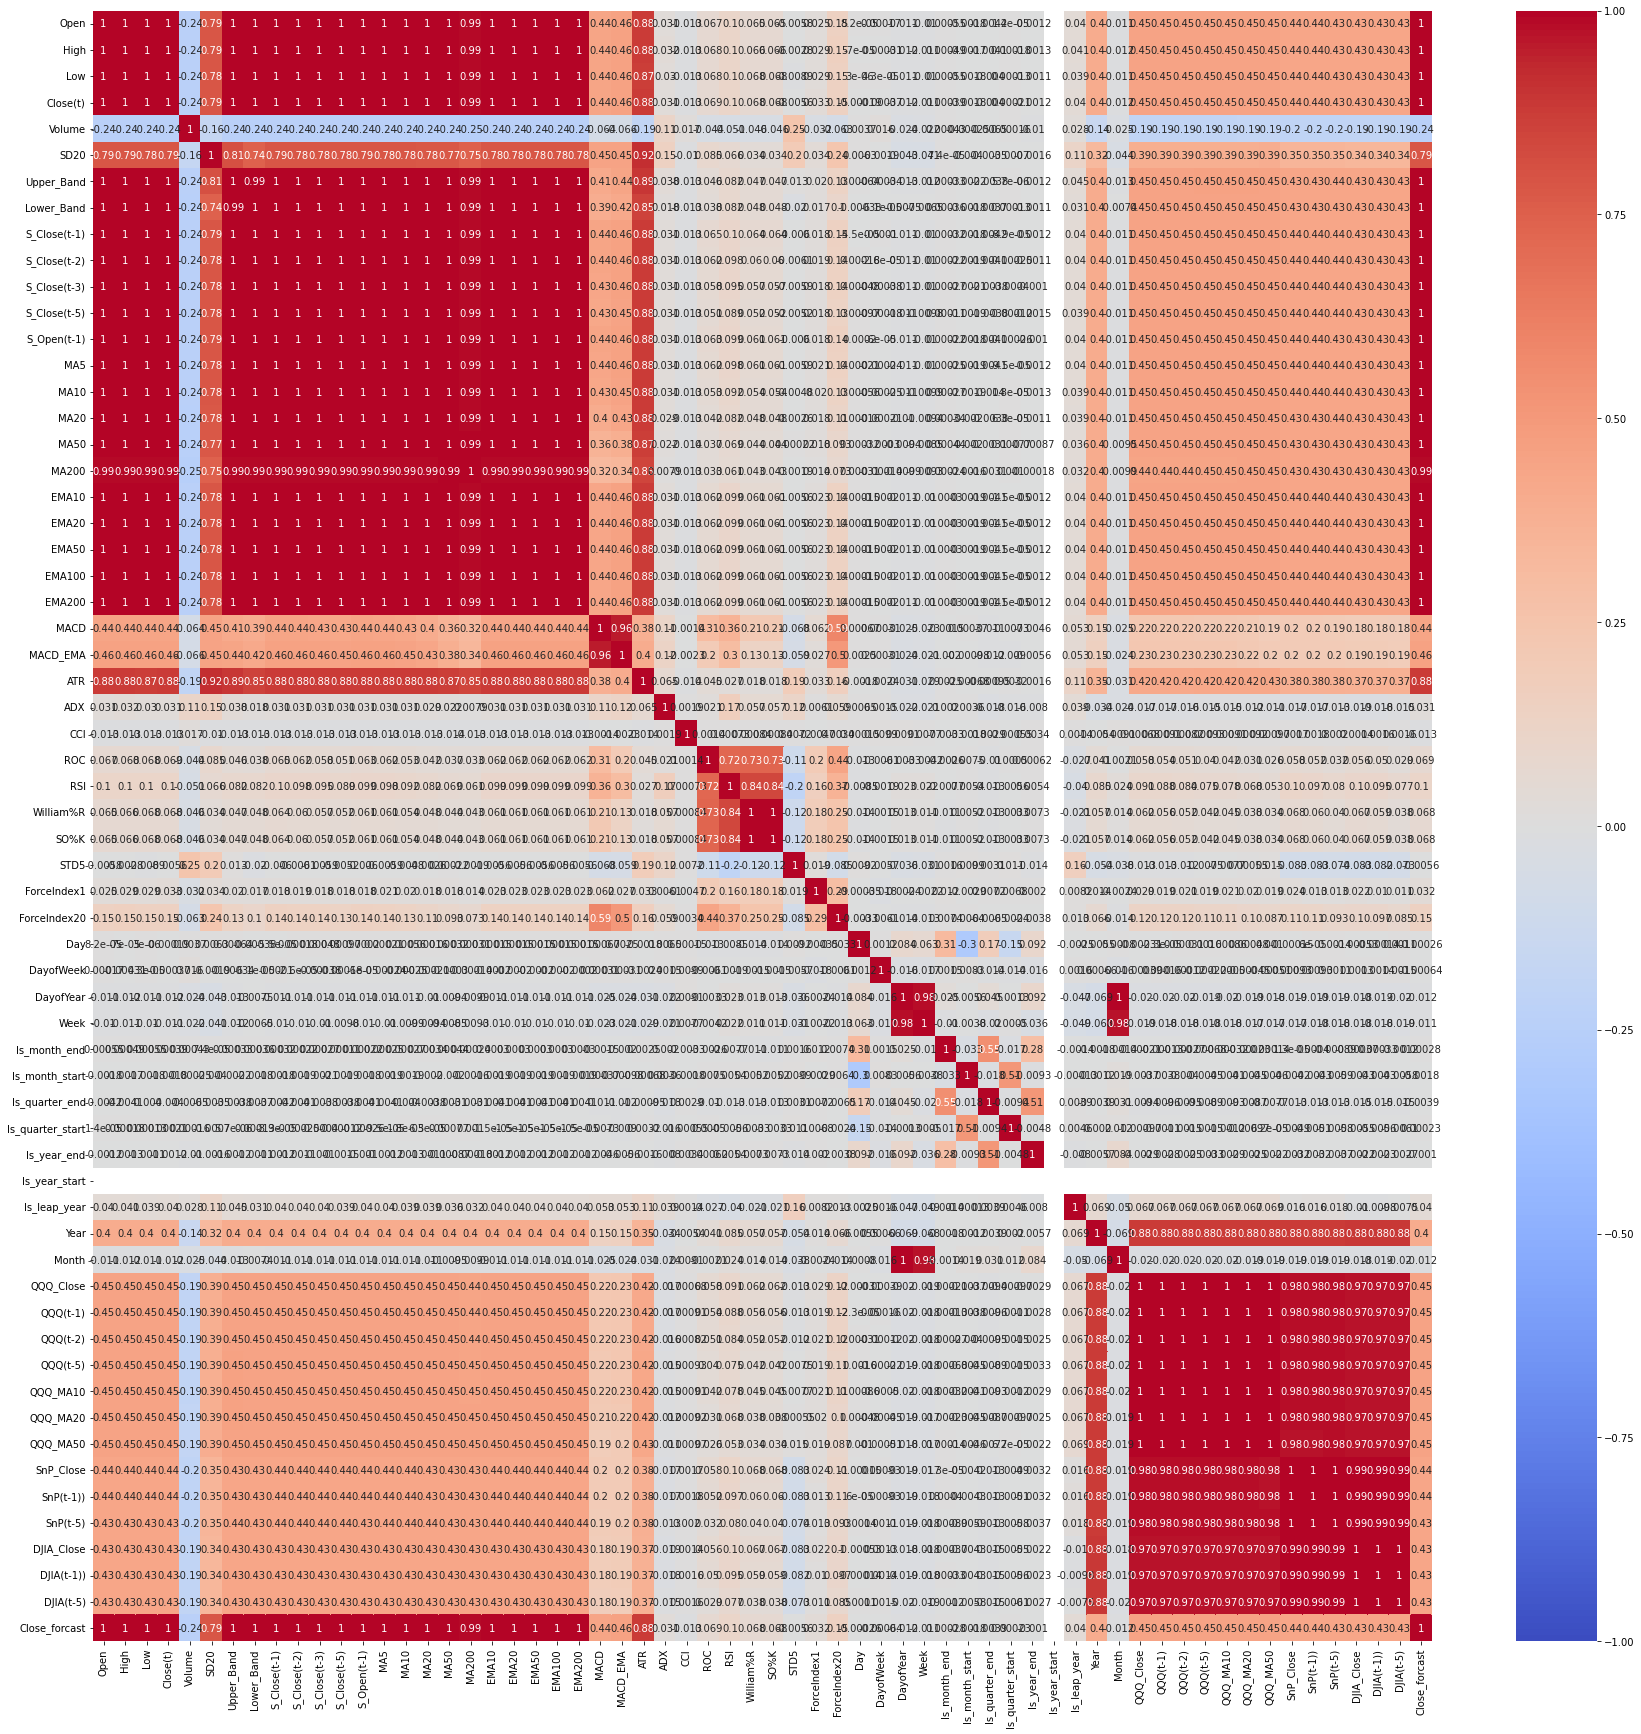

In [16]:
# scatter matrix
plt.figure(figsize=(30,30))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')